# LangGraph practice # 3



## 구성도

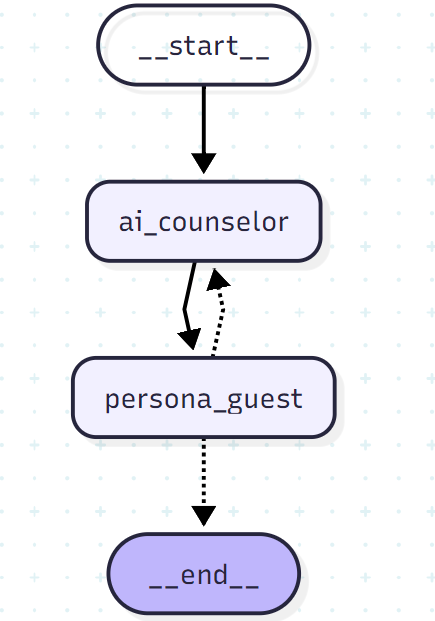

[잘된 예시 flow log](https://smith.langchain.com/public/b790b132-bee3-4f45-865f-ea7daf31d894/r)

In [1]:
import os,sys
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('utils'), '..')))
from module.utils import * 
from module.prompt import * 
from module.custom_model import *

In [2]:
from typing import TypedDict, Annotated, List, Literal
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import AIMessage,HumanMessage

In [3]:
strt_langsmith('practice_3')

LangSmith 추적을 시작합니다.
[프로젝트명]
practice_3


In [4]:

class State(TypedDict):
    messages : Annotated[list,add_messages] # 상호 대화

In [5]:
def _swap_roles(messages):
    # 메시지의 역할을 교환: 시뮬레이션 사용자 단계에서 메시지 타입을 AI -> Human, Human -> AI 로 교환합니다.
    new_messages = []
    for m in messages:
        if isinstance(m, AIMessage):
            # AIMessage 인 경우, HumanMessage 로 변환합니다.
            new_messages.append(HumanMessage(content=m.content))
        else:
            # HumanMessage 인 경우, AIMessage 로 변환합니다.
            new_messages.append(AIMessage(content=m.content))
    return new_messages

def ai_response(messages)->list:
    prompt = get_prompt_assistant()
    llm = get_gemini()
    chain = prompt | llm | StrOutputParser()
    result = chain.invoke({'messages':messages})
    return result

def persona_response(messages)->list:
    swap_messages = _swap_roles(messages)
    prompt = get_prompt_persona()
    llm = get_gemini()
    chain = prompt | llm | StrOutputParser()
    return chain.invoke({'messages':swap_messages})

In [6]:
def ai_counselor(state : State) -> State:
    """
        고객의 요청을 응답해주는 상담 챗봇
    """
    messages = state['messages']
    response = ai_response(messages)
    return State({'messages':[AIMessage(content=response)]})


def persona_guest(state : State) -> State:
    """
        컴플레인 요청을 하는 손님 역할 
    """
    messages = state['messages']
    response = persona_response(messages)
    return State({'messages':[HumanMessage(content=response)]})

def should_coninue(state:State)-> Literal['ai_counselor',END]:
    messages=state['messages']
    latest_messages = messages[-1].content
    if len(messages) > 10:
        return END
    if latest_messages == 'FINISHED':
        return END
    else:
        return 'ai_counselor'


In [7]:
state_graph = StateGraph(State)
state_graph.add_node('ai_counselor',ai_counselor)
state_graph.add_node('persona_guest',persona_guest)

state_graph.add_edge(START,'ai_counselor')
state_graph.add_edge('ai_counselor','persona_guest')
state_graph.add_conditional_edges(
    source='persona_guest',
    path=should_coninue
)
memory = get_check_pointer()
graph = state_graph.compile(checkpointer=memory)

In [10]:
# visualize_graph(graph)
print(graph.get_graph().draw_mermaid())

---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	ai_counselor(ai_counselor)
	persona_guest(persona_guest)
	__end__([<p>__end__</p>]):::last
	__start__ --> ai_counselor;
	ai_counselor --> persona_guest;
	persona_guest -.-> __end__;
	persona_guest -.-> ai_counselor;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



In [9]:
uuid = get_random_uuid()
config = get_runnable_config(recursion_limit=10,thread_id=uuid)

query = '로봇에 충돌이 발생했어 해결하는 방법알려줘'
inputs = State({'messages':[HumanMessage(content=query)]})
# for event in graph.stream(inputs,config):
#     print(event)
# event = graph.invoke(inputs,config)
# print(event)
invoke_graph(graph,inputs,config)
# stream_graph(graph,inputs,config)


🔄 Node: ai_counselor 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================

안녕하세요, 로버트 치킨 시스템 지원 챗봇입니다. 로봇 충돌 발생으로 불편을 겪으셨다니 죄송합니다.

로봇 충돌은 안전을 위해 즉시 조치가 필요한 상황입니다. 아래의 절차에 따라 문제를 해결해 보시기 바랍니다.

**1. 즉시 로봇 작동 중지:**

*   가장 먼저, 로봇의 **비상 정지 버튼**을 눌러 로봇의 작동을 즉시 중지시켜 주십시오. 비상 정지 버튼은 로봇 본체 또는 제어판에서 쉽게 찾으실 수 있습니다.

**2. 충돌 지점 확인 및 안전 확보:**

*   로봇이 멈춘 후, 충돌이 발생한 지점을 육안으로 확인해 주십시오.
*   충돌로 인해 로봇 또는 주변 환경에 파손된 부분이 있는지 주의 깊게 살펴보십시오.
*   안전을 위해 충돌 지점 주변에 사람이 접근하지 않도록 통제해 주십시오.

**3. 로봇 상태 점검:**

*   **시각적 점검:** 로봇 팔, 관절, 센서 등에 눈에 띄는 파손이나 변형이 있는지 확인합니다.
*   **움직임 점검 (주의 필요):** 로봇이 완전히 멈춘 상태에서, 로봇 팔을 수동으로 아주 조심스럽게 움직여 보면서 걸리는 부분이나 이상한 소리가 나는지 확인합니다. **이때, 로봇에 전원이 공급된 상태라면 매우 주의해야 하며, 무리한 힘을 가하지 않도록 합니다.**

**4. 충돌 원인 파악 (가능한 경우):**

*   충돌이 발생한 당시 로봇이 어떤 작업을 수행 중이었는지, 주변에 장애물이 있었는지 등을 기억해 보시면 원인 파악에 도움이 될 수 있습니다.

**5. 시스템 재시작 및 테스트:**

*   충돌로 인한 명백한 파손이 없고, 로봇이 정상적으로 움직이는 것으로 판단되면 시스템을 재시작해 볼 수 있습니다.
*   **시스템 재시작 전